In [40]:
import MDAnalysis as md
import numpy as np 
import matplotlib.pyplot as plt
from MDAnalysis.analysis.distances import distance_array, between


In [2]:
def py_angle(v1, v2):
    """Returns the angle in radians between the vectors v1 and v2 using the cosine relation"""
    dot = np.dot(v1, v2)
    v1_len = np.linalg.norm(v1)
    v2_len = np.linalg.norm(v2)
    return np.arccos(dot / (v1_len * v2_len) )

In [3]:
def get_leaflet_index (gl1, po4, resid_index):
    no_lipids = po4.shape[0]
    normal = np.array([0, 0, 1])
    Top = []
    Bot = []
    angles = []
    for i in range(no_lipids):
        vector = gl1[i] - po4[i]
        a = py_angle(vector, normal)
        angles.append(a)
        if a < 1.5:
            Top.append(resid_index[i])
        else:
            Bot.append(resid_index[i])
    return np.array(Top), np.array(Bot), angles

In [4]:
def write_ndx(top, bot, frame, name):
    top_res = " ".join(["{0:d}".format(i) for i in top])
    bot_res = " ".join(["{0:d}".format(i) for i in bot])
    top_sel = u.select_atoms('resname POPC and resid {0:s}'.format(top_res))
    bot_sel = u.select_atoms('resname POPC and resid {0:s}'.format(bot_res))
    with md.selections.gromacs.SelectionWriter('{0:s}_TEST_leaflets_frame_{1:d}.ndx'.format(name,frame), mode='w') as ndx:
        ndx.write(top_sel, name='Top_leaf')
        ndx.write(bot_sel, name='Bot_leaf')
    return

In [34]:
def identify_lipids_between(u, cutoff=10):
    """In principal it should work, but it does not"""
    p = u.select_atoms('resname POPC')
    np.unique(u.select_atoms('protein').resids)
    natoms_prot = u.select_atoms('name BB').n_atoms
    chain_atoms = natoms_prot / 2
    chainA = u.select_atoms('protein')[:chain_atoms]
    chainB = u.select_atoms('protein')[-chain_atoms:]
    B = " ".join(["{0:d}".format(i) for i in chainB.indices])
    A = " ".join(["{0:d}".format(i) for i in chainA.indices])
    chainB_sel = u.select_atoms("bynum {0:s}".format(B))
    chainA_sel = u.select_atoms("bynum {0:s}".format(A))
    sel = between(p, chainA_sel, chainB_sel, cutoff)
    #name_out = output+'_lipids_in_between.txt'
    #np.savetxt(name_out, np.unique(sel.resids))
    return sel

In [24]:
def measure_thickness (top, bot, u, diameter):
    """Measure the distance between the PO4 beads in the selections
    But not sure it works correct"""
    top_res = " ".join(["{0:d}".format(i) for i in top ])
    bot_res = " ".join(["{0:d}".format(i) for i in bot ])
    
    radii = np.arange(6, diameter, 10).shape[0]
    distances = np.zeros([2, radii])
    for idx, r in enumerate(np.arange(6, diameter, 10)):
        top_sel = u.select_atoms('sphzone {0:d} (resname POPC and resid {1:s})'.format(r, top_res))
        bot_sel = u.select_atoms('sphzone {0:d} (resname POPC and resid {1:s})'.format(r, bot_res))
        d = distance_array(top_sel.positions, bot_sel.positions)
        distances[0, idx] = r
        distances[1, idx] = np.mean(d)
    return distances

In [7]:
u = md.Universe('GRO/NW11_80_v1_nowat.gro','XTC/NW11_80_v1_nowat_fit.xtc')
name = 'NW11_80_v1_TEST'

/home/au447022/anaconda3/envs/py2.7/lib/python2.7/site-packages/MDAnalysis/topology/guessers.py:72: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/au447022/anaconda3/envs/py2.7/lib/python2.7/site-packages/MDAnalysis/topology/guessers.py:72: UserWarning: Failed to guess the mass for the following atom types: G
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


In [8]:
popc = u.select_atoms('resname POPC').resids

In [9]:
resid_index = np.unique(popc)

In [35]:
Angle_distribution = []
Dist = []
#file_out_lipid = open('{0:s}_lipids_in_between.txt'.format(name), 'w')
#file_out_lipid.write('System {0:s}, cutoff={1:d}\n'.format(name, 10))
#file_out_lipid.write('#############################\n')

T = []
B = []

for idx, ts in enumerate(u.trajectory[1::100]):
    frame  = u.trajectory.frame
    po4 = u.select_atoms('name PO4').positions
    gl1 = u.select_atoms('name GL1').positions
    top, bot, a = get_leaflet_index(gl1, po4, resid_index)
    Angle_distribution.append(a)
    T.append(top)
    B.append(bot)
    #in_lipids = identify_lipids_between(u)
    #file_out_lipid.write('Frame {0:d}, Lipid resid:\n'.format(frame))
    #for i in np.unique(in_lipids.resids):
    #    file_out_lipid.write('{0:d}  '.format(i))
    #file_out_lipid.write('\n')
    write_ndx(top, bot, frame, name)
    #Dist.append(measure_thickness(top, bot, u, 110))
    #plt.plot(np.array(Dist[idx])[0,:], np.array(Dist[idx])[1,:])
print 'No. frames', idx+1
#file_out_lipid.close()
#plt.grid()
#plt.xlabel('Angstrom going from COM of selection and out')
#plt.ylabel('Thickness measure as mean distance between PO4 beads [Angstrom]')
#plt.show()


No. frames 233


In [36]:
nframes, nlipids = np.array(Angle_distribution).shape

Text(0,0.5,'Distribution for each frame')

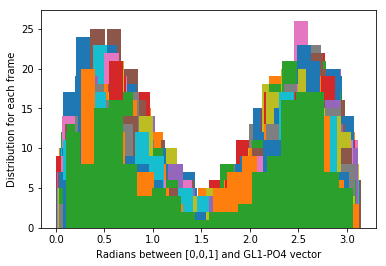

In [37]:
for a in Angle_distribution:
    plt.hist(a, bins=20)
plt.xlabel('Radians between [0,0,1] and GL1-PO4 vector')
plt.ylabel('Distribution for each frame')

In [38]:
T

[array([275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287,
        288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300,
        301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313,
        314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326,
        327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339,
        340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352,
        353, 354], dtype=int32),
 array([237, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286,
        287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299,
        300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312,
        313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325,
        326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 339,
        340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352,
        353, 354], dtype=int32),
 array([275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 